In [46]:
import tensorflow as tf

from tensorflow import keras
from keras import datasets, layers, models
from keras.models import Sequential

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from pathlib import Path

In [47]:
batch_size = 32
img_height = 180
img_width = 180
processed_datasets_directory = "data"

In [48]:
train_dir = Path("train")
validate_dir = Path("validate")


def fetch_datasets(folder_name):
  print("\nFetching datasets in:", folder_name)
  datasets = {}
  for source in Path(processed_datasets_directory + "/" + folder_name).glob("*"):
    datasets[source.name] = tf.keras.utils.image_dataset_from_directory(
      source,
      image_size=(img_height, img_width),
      batch_size=batch_size
    )
  return datasets

test_datasets = fetch_datasets("test")
train_datasets = fetch_datasets("train")
validate_datasets = fetch_datasets("validate")


Fetching datasets in: test
Found 400 files belonging to 4 classes.
Found 12 files belonging to 4 classes.
Found 3924 files belonging to 4 classes.
Found 2080 files belonging to 4 classes.
Found 1192 files belonging to 4 classes.
Found 1116 files belonging to 4 classes.
Found 180 files belonging to 4 classes.

Fetching datasets in: train
Found 2800 files belonging to 4 classes.
Found 100 files belonging to 4 classes.
Found 27432 files belonging to 4 classes.
Found 14608 files belonging to 4 classes.
Found 8344 files belonging to 4 classes.
Found 8084 files belonging to 4 classes.
Found 1336 files belonging to 4 classes.

Fetching datasets in: validate
Found 796 files belonging to 4 classes.
Found 24 files belonging to 4 classes.
Found 7856 files belonging to 4 classes.
Found 4160 files belonging to 4 classes.
Found 2392 files belonging to 4 classes.
Found 2276 files belonging to 4 classes.
Found 368 files belonging to 4 classes.


In [49]:
train_datasets

{'astro_objects': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'cubes': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'extracted_images': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'illustrations': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'nature': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 'scans': <BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,


In [51]:
def merge_datsets(datasets):
  merged_dataset = np.array
  for dataset in datasets.values():
    # merged_dataset = dataset.concatenate(merged_dataset) if merged_dataset else dataset
    merged_dataset = tf.concat(merged_dataset) if merged_dataset else dataset
  
  return merged_dataset
  #return np.concatenate(datasets.values(), 1)

# train_ds = tf.data.Dataset.zip(tuple(train_datasets.values()))
# train_ds = tf.data.Dataset.sample_from_datasets(train_datasets.values())

# train_ds = merge_datsets(train_datasets)
train_ds = train_datasets['extracted_images']

['0', '180', '270', '90']


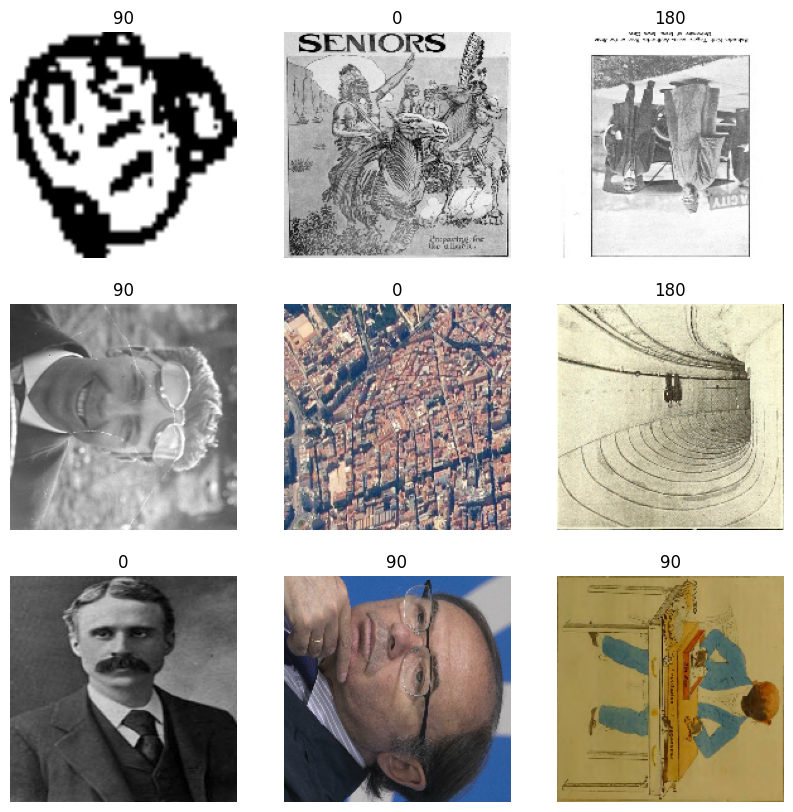

In [52]:
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [53]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

(32, 180, 180, 3)
(32,)
0.07407203 0.9603484


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

In [55]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## Dropout

In [56]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [60]:
epochs=10
history = model.fit(
  train_ds,
  # validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
481/858 [===============>..............] - ETA: 5:15 - loss: 1.2295 - accuracy: 0.4545

KeyboardInterrupt: 

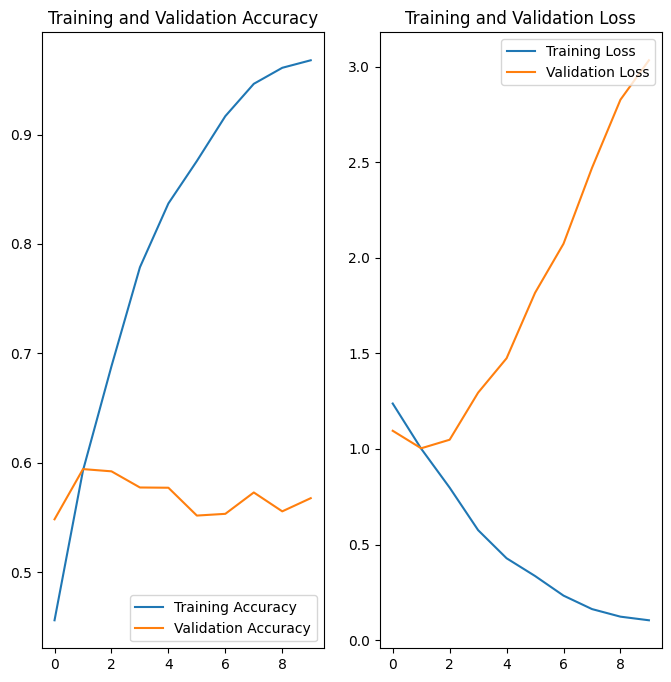

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## References
 - https://www.tensorflow.org/tutorials/load_data/images
 